In [1]:
#imports 
import wisps
import splat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database










In [2]:
#constants
sns.set_palette('husl')

fltrswfc3= ['WFC3_{}'.format(k) for k in ['F110W', 'F140W', 'F160W']]

#load spectra
bonafide_data=pd.read_pickle(wisps.OUTPUT_FILES+'/validated_spectra.pkl')

In [3]:
#load spectra
#bonafide_spectra

In [4]:
#functions 
def measure_all_mags(sp):
    mags={}
    for k in fltrswfc3:
        mags.update( measure_mag(sp, k))
        
    return mags
        

def measure_mag(sp, flt):
    #flux calibrate
    #sp.trim([1.1, 1.7])
    plt.plot(sp.wave, sp.flux)
    mag, mag_unc = splat.filterMag(sp, flt, ab=True, nsamples=1000)
    return {flt: [mag, mag_unc], 'spectra':sp }

def scale_spectrum(sp):
    med_flux=np.nanmedian(sp.flux.value[np.logical_and(sp.wave.value >=1.2, sp.wave.value<=1.3 )])
    #print (med_flux)
    sp.scale(REF_FLUX/med_flux)

    return sp

def make_wisp_spectra(sp):
    try:
        #print (sp.noise.value)
        return wisps.Spectrum(wave=sp.wave.value, flux=sp.flux.value, noise=sp.noise.value, \
                              contam=np.ones(len(sp.flux.value)))
    except:
        return

In [5]:
spectral_types=np.vstack(bonafide_data)[:,0]
bonafide_spectra=np.vstack(bonafide_data)[:,1]

In [6]:
#spectral_types

In [7]:
ydwrf=bonafide_spectra[spectral_types>38.0][0]

In [8]:
#splat.filterMag(ydwrf, 'WFC3_F110W')

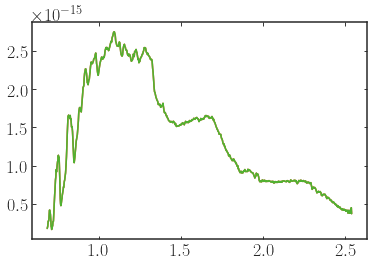

In [9]:
#reference mdwarf
REF_MDWARF=bonafide_spectra[spectral_types==17.][0]
#wavelength range
REF_FLUX= np.nanmedian(REF_MDWARF.flux[np.logical_and(REF_MDWARF.wave.value >=1.2, REF_MDWARF.wave.value<=1.3 )])

REF_MAG={}
for k in fltrswfc3:
    REF_MAG.update(measure_mag(REF_MDWARF, k))

In [10]:
REF_MAG

{'WFC3_F110W': [23.15346612782537, 0.004827226475587359],
 'spectra': SPEX-PRISM spectrum of TVLM 831-154910,
 'WFC3_F140W': [22.617349515739225, 0.004980457843659938],
 'WFC3_F160W': [22.410531284932276, 0.00515574825458608]}

100%|██████████| 336/336 [15:34<00:00,  2.78s/it]


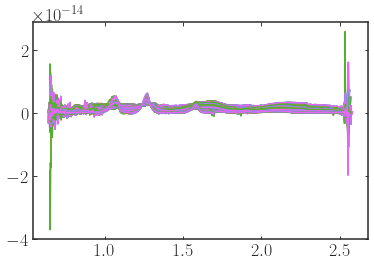

In [11]:
scaled_spectra= [scale_spectrum(x) for x in bonafide_spectra]
scale_mags=[measure_all_mags(xi) for xi in tqdm(scaled_spectra) ]

Text(0, 0.5, 'Flux (normalized)')

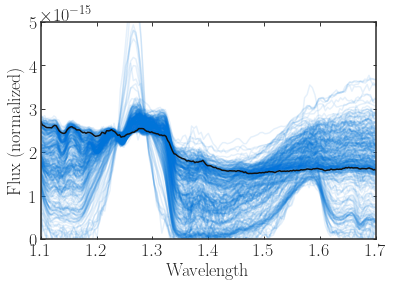

In [12]:
for x in scaled_spectra:
    plt.plot(x.wave, x.flux, alpha=0.1, c='#0074D9')

plt.plot(REF_MDWARF.wave, REF_MDWARF.flux, c='#111111')
plt.xlim([1.1, 1.7])
plt.ylim([0.0, 0.5e-14])
plt.xlabel('Wavelength')
plt.ylabel('Flux (normalized)')

In [13]:
#splat.filterMag?

In [14]:
#splat.filterMag(ydwrf, '2MASS H', ab=True, nsamples=1000)

In [15]:
df=pd.DataFrame()

In [16]:
df['wispsp']=[make_wisp_spectra(x) for x in bonafide_spectra]

In [17]:
nones=df.wispsp.isna().values

In [18]:
snr_df=pd.DataFrame.from_records(df['wispsp'][~nones].apply(lambda x: x.snr).values)

In [19]:
#snr.snr1.plot(kind='hist')

In [20]:
mag_df=pd.DataFrame.from_records(scale_mags)[~nones]
#mag_df['wispectra']=bonafide_spectra['wispsp']
mag_df['snr1']=snr_df.snr1
mag_df['snr3']=snr_df.snr3
mag_df['medsnr']=snr_df.snr4
mag_df['spt']=spectral_types[~nones]
#mag_df['spt_er']=[x.spectral_type[1] for x in bonafide_spectra]

In [21]:
for k in ['F110W', 'F140W', 'F160W']:
    mgkey='WFC3_{}'.format(k)
    #compute offsets and uncertainties using standard error propagation
    mag_df['rel'+k]= np.vstack(mag_df[mgkey].values)[:,0]-REF_MAG[mgkey][0]
    mag_df['rel'+k+'_er']=((np.vstack(mag_df[mgkey].values)[:,1])**2+(REF_MAG[mgkey][1])**2)**0.5


In [22]:
#delete outliers
mag_df=(mag_df[mag_df.snr1 >1.]).reset_index(drop=True)

In [23]:
mag_df.columns

Index(['WFC3_F110W', 'spectra', 'WFC3_F140W', 'WFC3_F160W', 'snr1', 'snr3',
       'medsnr', 'spt', 'relF110W', 'relF110W_er', 'relF140W', 'relF140W_er',
       'relF160W', 'relF160W_er'],
      dtype='object')

In [24]:
mag_df['dF110W']= 100**(mag_df['relF110W']/5)

In [25]:
YET_ANOTHER_POLYNOMIAL={}

In [26]:
#plt.plot(mag_df.spt, mag_df.relF140W, '^')
mag_df=mag_df.dropna()#.spt.max()

In [27]:
def tick_function(mags):
    return ['{:.1f} pc'.format(wisps.get_distance(0, x)) for x in mags]

In [28]:
#mag_df

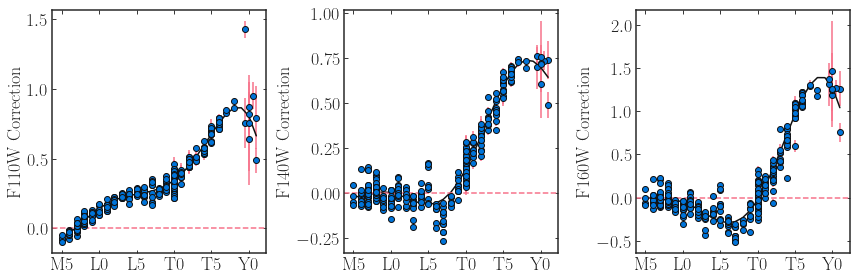

In [38]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4), sharey=False)
for idx, flt in enumerate(['rel'+k for k in ['F110W', 'F140W', 'F160W']]):

    mask, pol=wisps.fit_with_nsigma_clipping(mag_df.spt.values.astype(float), 
                                             mag_df[flt].values.astype(float), 
                                             mag_df[flt+'_er'].values.astype(float), n=6, sigma=5)
    ax[idx].errorbar( mag_df.spt, mag_df[flt], yerr=mag_df[flt+'_er'], fmt='o', mec='#111111', mfc='#0074D9', alpha=1.)
    #c=ax[idx].scatter( mag_df.spt, mag_df[flt], c=mag_df.snr1.apply(np.log10), cmap='coolwarm', s=40)
    
    xvl=mag_df.spt.values
    yvl=mag_df[flt].values

    YET_ANOTHER_POLYNOMIAL.update({flt.replace('rel', ""):(pol, abs(yvl[mask]-pol(xvl[mask])).mean())})

    ax[idx].set_xticks([15, 20, 25, 30, 35, 40])
    ax[idx].set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])

    ax[idx].set_ylabel('{} Correction'.format(flt.replace('rel', "")))

    #ax2 = ax[idx].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.set_ylabel('Distance Correction', color='#FF851B')  # we already handled the x-label with ax1
    #ax2.plot( mag_df.spt, mag_df['dF110W'],  fmt='o', mec='#111111', mfc='#FF851B', alpha=0.)
    #ax2.plot( mag_df.spt, mag_df['dF110W'],  '^', color='#FF851B', alpha=0.1)
    #ax2.set_ylabel('Distance Correction')
    #ax2.tick_params(axis='y', color='#FF851B')
    #ax2.set_ylim(ax[idx].get_ylim())
    #new_tick_locations = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
    #ax2.set_yticks(new_tick_locations)
    #ax2.set_yticklabels(tick_function(new_tick_locations))
    #ax2.tick_params(colors='#0074D9', which='both') 

    #color = 
    #ax[idx].minorticks_on()
    ax[idx].plot(np.arange(15, 42), pol(np.arange(15, 42)), c='#111111')
    ax[idx].axhline(0.0, linestyle='--')

    plt.tight_layout()


    plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limits_corrections.pdf',  rasterized=True, bbox_inches='tight')
    #plt.ylim([-1, 4])
    #plt.xlabel('Spectral Type')
    #plt.ylabel('Magnitude offset from standard M7')
    #plt.colorbar(c)
   

In [30]:
 np.shape(scaled_spectra)

(336,)

In [31]:
rels=wisps.POLYNOMIAL_RELATIONS

In [32]:
rels.update({'mag_limit_corrections': YET_ANOTHER_POLYNOMIAL})

In [33]:
#jklasad

In [34]:
#/polynomial_relations.pkl'
import pickle
output = open(wisps.OUTPUT_FILES+'/polynomial_relations.pkl', 'wb')
pickle.dump(rels, output)
output.close()


In [35]:
#all_spectra